In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

In [2]:
n_classes_SIC = 12
LABELS_SIC = {
    0: 0,
    1: 10,
    2: 20,
    3: 30,
    4: 40,
    5: 50,
    6: 60,
    7: 70,
    8: 80,
    9: 90,
    10: 100
}
CLABEL_SIC = 'Sea Ice Concentration [%]'

n_classes_SOD = 7
LABELS_SOD = {
    0: 'Open \nwater',
    1: 'New \nIce',
    2: 'Young \nice',
    3: 'Thin \nFYI',
    4: 'Thick \nFYI',
    5: 'Old \nice',
}
CLABEL_SOD = 'Stage of Development'

n_classes_FLOE = 8
LABELS_FLOE = {
    0: 'Open \nwater',
    1: 'Cake \nIce',
    2: 'Small \nfloe',
    3: 'Medium \nfloe',
    4: 'Big \nfloe',
    5: 'Vast \nfloe',
    6: 'Bergs'
}
CLABEL_FLOE = 'Floe Size'

In [14]:
def cbar_ice_classification(ax, n_classes, LABELS, CBAR_LABEL, cmap='viridis'):
    arranged = np.arange(0, n_classes)
    cmap = plt.get_cmap(cmap, n_classes - 1)
    norm = mpl.colors.BoundaryNorm(arranged - 0.5, cmap.N)
    arranged = arranged[:-1]  # Discount the mask class.
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                        ticks=arranged, fraction=0.0485, pad=0.049, ax=ax)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(label=CBAR_LABEL, fontsize=12)
    cbar.set_ticklabels(list(LABELS.values()))

def diff_plot(ax, scene1, scene2, title1, title2):
    ax.set_title("Differences between \n" + title1 + " and \n" + title2)
    diff = np.abs(np.subtract(scene1, scene2))
    im = ax.imshow(diff, cmap='hot_r')
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(label='Difference', fontsize=12)


def diff_correct_predictions(ax1, ax2, ax3, scene1, scene2, scene3, chart, n_classes, LABELS, CLABEL, title1, title2, title3):
    diff_scene_mask = (scene1 == scene2) & (scene1 == scene3) & (scene2 == scene3) #scene1 == scene2 == scene3 # True where same predictions
    scene1[diff_scene_mask] = np.nan
    scene2[diff_scene_mask] = np.nan
    scene3[diff_scene_mask] = np.nan


    scene1_chart_mask = scene1 != chart
    scene2_chart_mask = scene2 != chart
    scene3_chart_mask = scene3 != chart


    scene1[scene1_chart_mask] = np.nan
    scene2[scene2_chart_mask] = np.nan
    scene3[scene3_chart_mask] = np.nan


    ax1.set_title(title1)
    im1 = ax1.imshow(scene1, vmin=0, vmax=n_classes - 2, cmap='jet', interpolation='nearest')
    ax1.set_xticks([])
    ax1.set_yticks([])
    cbar_ice_classification(ax=ax1, n_classes=n_classes, LABELS=LABELS, CBAR_LABEL=CLABEL, cmap='jet')

    ax2.set_title(title2)
    im2 = ax2.imshow(scene2, vmin=0, vmax=n_classes - 2, cmap='jet', interpolation='nearest')
    ax2.set_xticks([])
    ax2.set_yticks([])
    cbar_ice_classification(ax=ax2, n_classes=n_classes, LABELS=LABELS, CBAR_LABEL=CLABEL, cmap='jet')

    ax3.set_title(title3)
    im3 = ax3.imshow(scene3, vmin=0, vmax=n_classes - 2, cmap='jet', interpolation='nearest')
    ax3.set_xticks([])
    ax3.set_yticks([])
    cbar_ice_classification(ax=ax3, n_classes=n_classes, LABELS=LABELS, CBAR_LABEL=CLABEL, cmap='jet')

def plot_uncertainty_results(scene1, scene2, scene3, chart, chart_variable, scene_variable, n_classes, LABELS, CLABEL, scene1_title, scene2_title, scene3_title, chart_title, title):
    chart_data = chart.variables[chart_variable].values
    mask = chart_data == 255

    chart_data = chart_data.astype(float)
    chart_data[mask] = np.nan

    data1 = scene1.variables[scene_variable + '_SIC'].values
    data1 = data1.astype(float)
    data1[data1 >= 11] = 10
    data1[mask] = np.nan

    data2 = scene2.variables[scene_variable + '_SIC'].values
    data2 = data2.astype(float)
    data2[data2 >= 11] = 10
    data2[mask] = np.nan

    data3 = scene3.variables[scene_variable + '_SIC'].values
    data3 = data3.astype(float)
    data3[data3 >= 11] = 10
    data3[mask] = np.nan

    fig, axes = plt.subplots(4, 7, figsize=(42, 24))
    fig.suptitle(title, fontsize=16)


    # SAR HH
    sar = chart.variables['nersc_sar_primary'].values
    sar = sar.astype(float)
    sar[mask] = np.nan
    ax = axes[0, 0]
    ax.set_title('HH SAR')
    im = ax.imshow(sar, cmap='gray')
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(label='Backscatter Coeff [dB]', fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

    # SAR HV
    sar = chart.variables['nersc_sar_secondary'].values
    sar = sar.astype(float)
    sar[mask] = np.nan
    ax = axes[0, 1]
    ax.set_title('HV SAR')
    im = ax.imshow(sar, cmap='gray')
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(label='Backscatter Coeff [dB]', fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

    # AMSR 18.7 h
    amsr = chart.variables['btemp_18_7h'].values
    ax = axes[0, 2]
    ax.set_title('18.7 GHz H')
    im = ax.imshow(amsr)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(label='TB [K]', fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

    # AMSR 18.7 v
    amsr = chart.variables['btemp_18_7v'].values
    ax = axes[0, 3]
    ax.set_title('18.7 GHz V')
    im = ax.imshow(amsr)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(label='TB [K]', fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

    # AMSR 36.5 h
    amsr = chart.variables['btemp_36_5h'].values
    ax = axes[0, 4]
    ax.set_title('36.5 GHz H')
    im = ax.imshow(amsr)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(label='TB [K]', fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

    # AMSR 36.5 v
    amsr = chart.variables['btemp_36_5v'].values
    ax = axes[0, 5]
    ax.set_title('36.5 GHz V')
    im = ax.imshow(amsr)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(label='TB [K]', fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

    # Chart data
    ax = axes[1, 0]
    ax.set_title(chart_title)
    im = ax.imshow(chart_data, vmin=0, vmax=n_classes - 2, cmap='jet', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    cbar_ice_classification(ax=ax, n_classes=n_classes, LABELS=LABELS, CBAR_LABEL=CLABEL, cmap='jet')

    # Scene 1
    ax = axes[1, 1]
    ax.set_title(scene1_title + ' SIC')
    im = ax.imshow(data1, vmin=0, vmax=n_classes - 2, cmap='jet', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    cbar_ice_classification(ax=ax, n_classes=n_classes, LABELS=LABELS, CBAR_LABEL=CLABEL, cmap='jet')

    # Scene 2
    ax = axes[1, 2]
    ax.set_title(scene2_title + ' SIC')
    im = ax.imshow(data2, vmin=0, vmax=n_classes - 2, cmap='jet', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    cbar_ice_classification(ax=ax, n_classes=n_classes, LABELS=LABELS, CBAR_LABEL=CLABEL, cmap='jet')

    # Scene 3
    ax = axes[1, 3]
    ax.set_title(scene3_title + ' SIC')
    im = ax.imshow(data3, vmin=0, vmax=n_classes - 2, cmap='jet', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    cbar_ice_classification(ax=ax, n_classes=n_classes, LABELS=LABELS, CBAR_LABEL=CLABEL, cmap='jet')


    # Blank
    #ax = axes[1, 4]
    #ax.set_xticks([])
    #ax.set_yticks([])


    # Blank
    #ax = axes[1, 5]
    #ax.set_xticks([])
    #ax.set_yticks([])

    # Differences CHART SCENE 1
    diff_plot(axes[2, 0], chart_data, data1, chart_title, scene1_title)
    # Differences CHART SCENE 1
    diff_plot(axes[2, 1], chart_data, data2, chart_title, scene2_title)
    # Differences Chart SCENE 3
    diff_plot(axes[2, 2], chart_data, data3, chart_title, scene3_title)

    # Differences SCENES 1-2
    diff_plot(axes[2, 3], data1, data2, scene1_title, scene2_title)
    # Differences SCENES 1-3
    diff_plot(axes[2, 4], data1, data3, scene1_title, scene3_title)
    # Differences SCENES 2-3
    diff_plot(axes[2, 5], data2, data3, scene2_title, scene3_title)


    # Blank
    #ax = axes[3, 0]
    #ax.set_xticks([])
    #ax.set_yticks([])

    # Correct predictions for each scene
    diff_correct_predictions(axes[1, 4], axes[1, 5], axes[1,6], data1, data2, data3, chart_data, n_classes, LABELS, CLABEL,
                             "Only Correct For: \n" + scene1_title, "Only Correct For: \n" + scene2_title, "Only Correct For: \n" + scene3_title)
    # Blank
    #ax = axes[3, 4]
    #ax.set_xticks([])
    #ax.set_yticks([])

    # Blank
    #ax = axes[3, 5]
    #ax.set_xticks([])
    #ax.set_yticks([])

    std_dev1 = scene1.variables[scene_variable + '_STD_DEV'].values
    std_dev1 = std_dev1.astype(float)
    std_dev1[mask] = np.nan

    std_dev2 = scene2.variables[scene_variable + '_STD_DEV'].values
    std_dev2 = std_dev2.astype(float)
    std_dev2[mask] = np.nan

    std_dev3 = scene3.variables[scene_variable + '_STD_DEV'].values
    std_dev3 = std_dev3.astype(float)
    std_dev3[mask] = np.nan

    # Diff VAR 1-2
    diff_plot(axes[3, 0], std_dev1, std_dev2, scene1_title + ' Std Dev', scene2_title + ' Std Dev')

    # Diff VAR 1-3
    diff_plot(axes[3, 1], std_dev1, std_dev3, scene1_title + ' Std Dev', scene3_title + ' Std Dev')

    # Diff VAR 2-3
    diff_plot(axes[3, 2], std_dev2, std_dev3, scene2_title + ' Std Dev', scene3_title + ' Std Dev')

    # VAR 1
    ax = axes[3, 3]
    ax.set_title(scene1_title + ' Std Dev')
    im = ax.imshow(std_dev1, cmap='inferno_r')
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(label='Std Dev [%]', fontsize=12)

    # VAR 2
    ax = axes[3, 4]
    ax.set_title(scene2_title + ' Std Dev')
    im = ax.imshow(std_dev2, cmap='inferno_r')
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(label='Std Dev [%]', fontsize=12)

    # VAR 3
    ax = axes[3, 5]
    ax.set_title(scene3_title + ' Std Dev')
    im = ax.imshow(std_dev3, cmap='inferno_r')
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(label='Std Dev [%]', fontsize=12)

    # Blank
    ax = axes[0,6]
    ax.set_xticks([])
    ax.set_yticks([])
    # Blank
    ax = axes[2, 6]
    ax.set_xticks([])
    ax.set_yticks([])
    # Blank
    ax = axes[3, 6]
    ax.set_xticks([])
    ax.set_yticks([])


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('/content/drive/MyDrive/Compare-Results/Figures/' + scene_variable + '_' + scene1_title.split(" ")[0] + '_' + scene2_title.split(" ")[0] + '.png')
    plt.show()

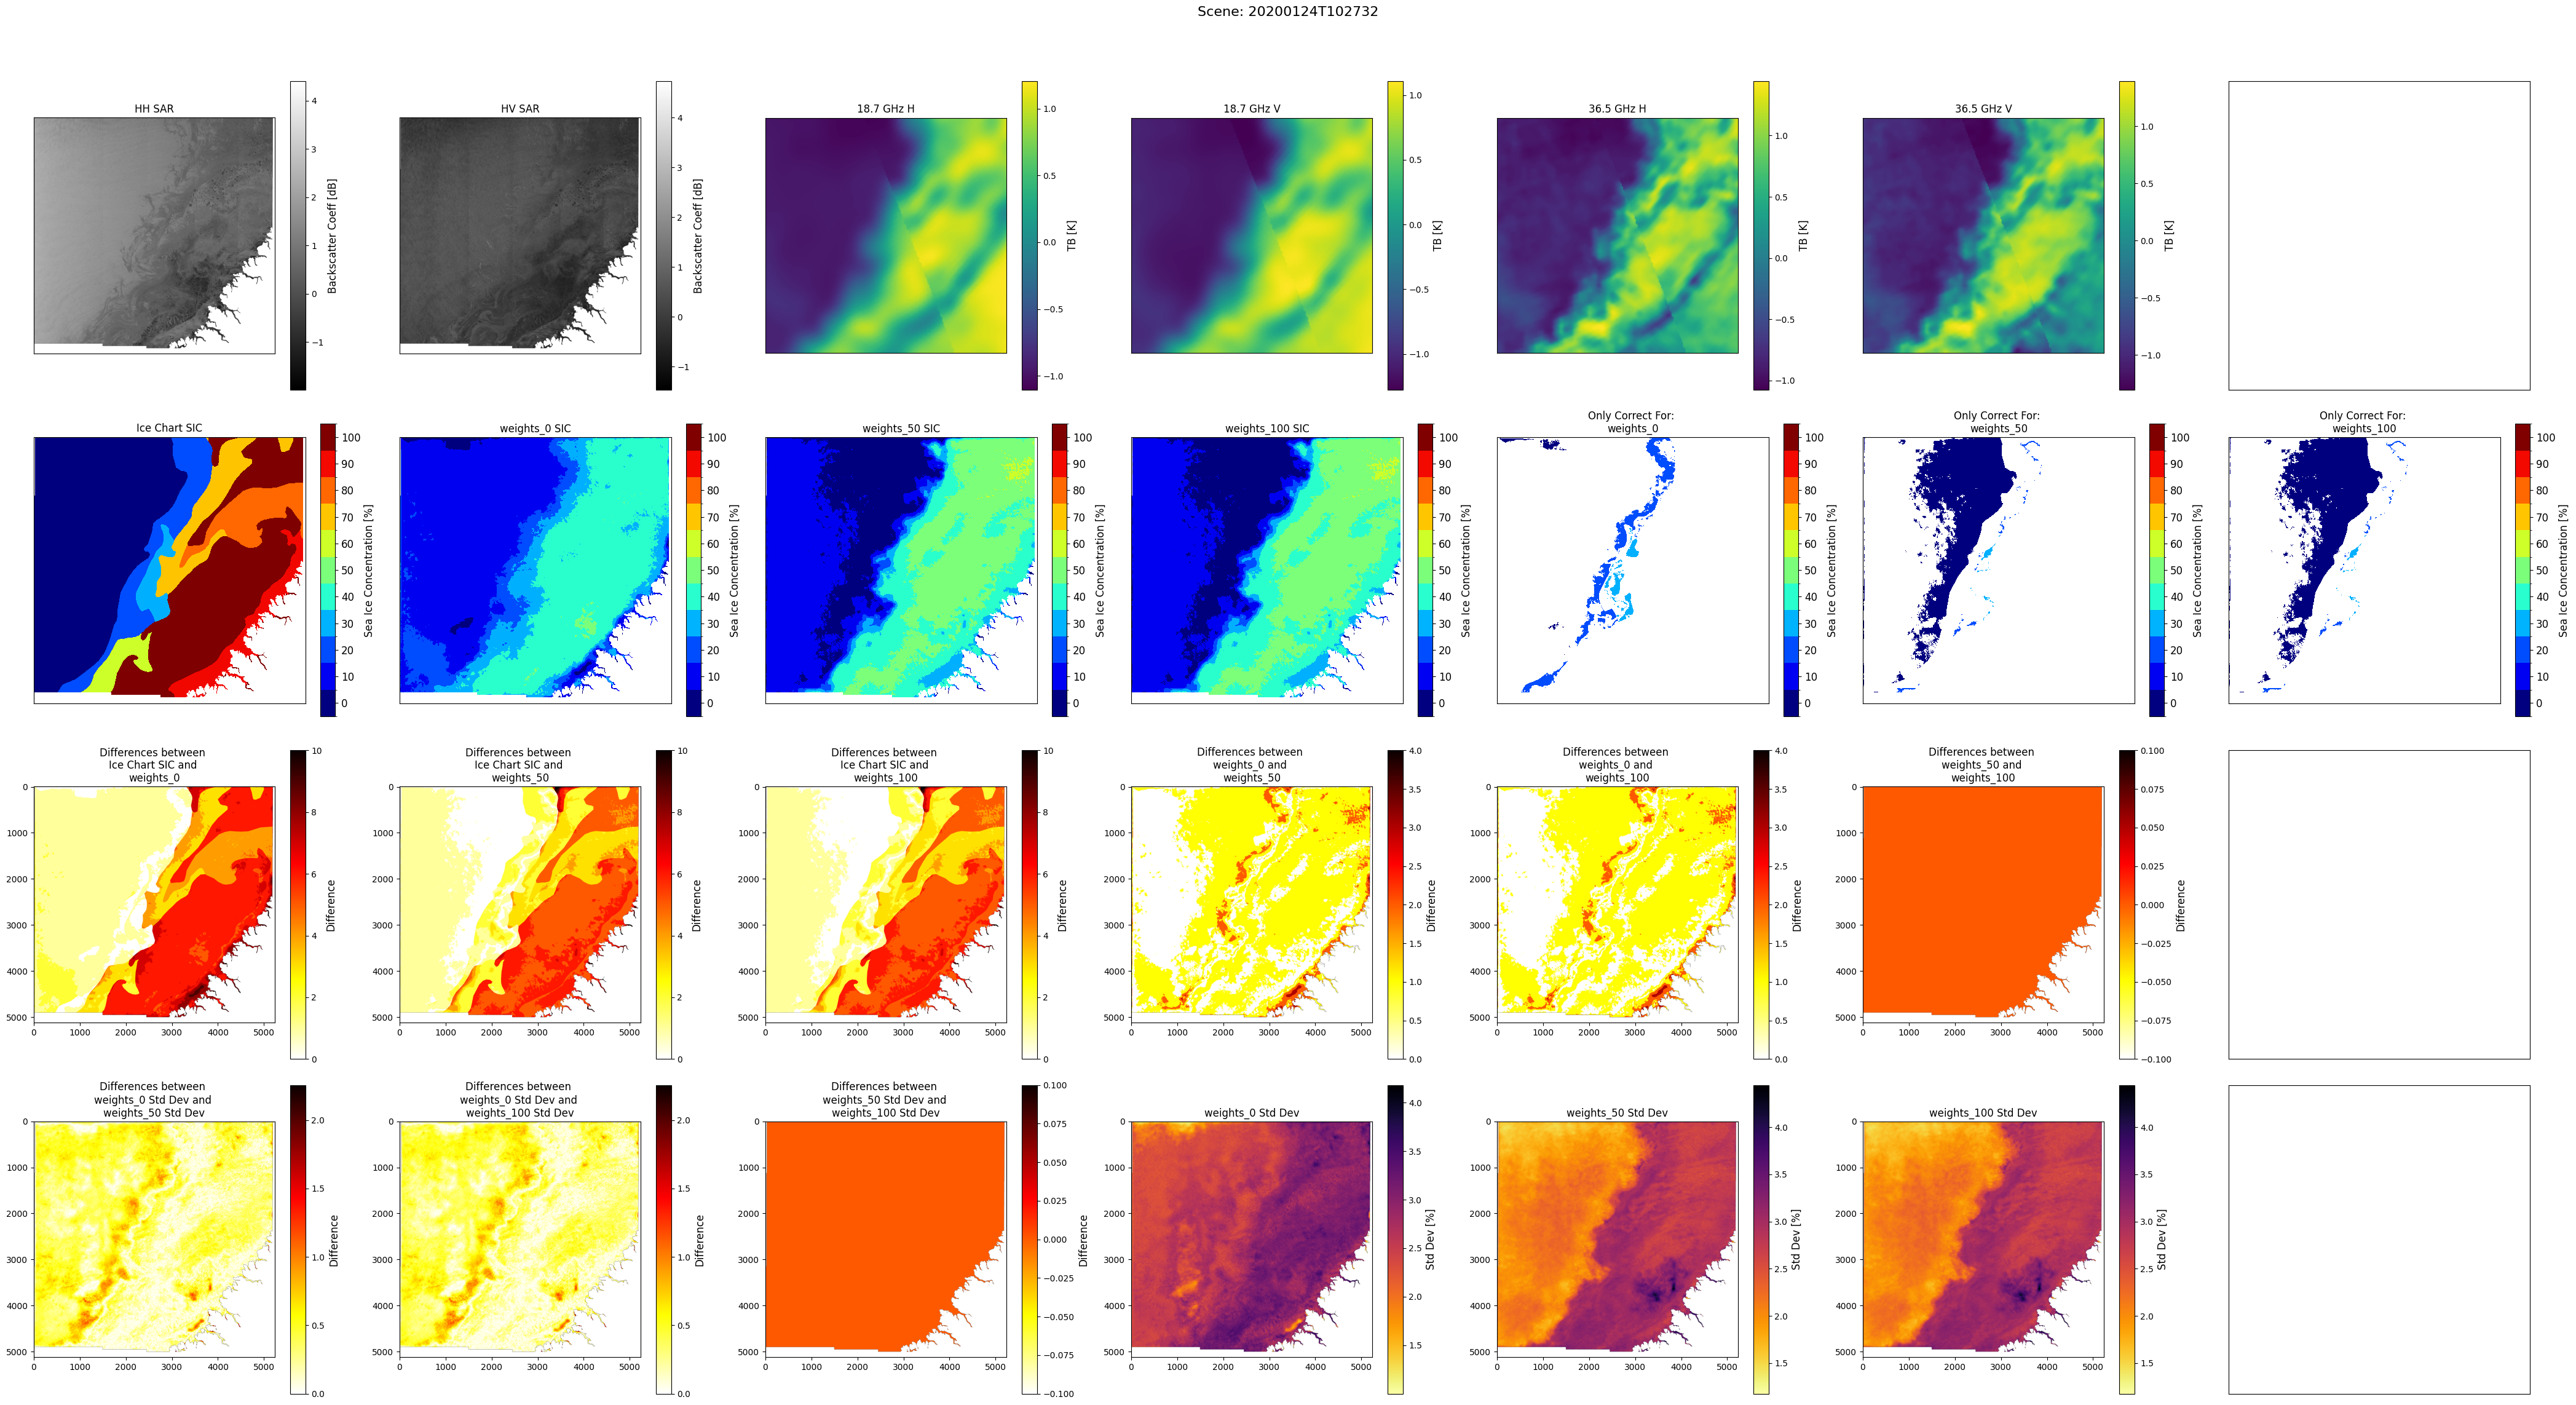

In [15]:
ice_chart_path = '/content/drive/MyDrive/Compare-Results/Charts/'
ice_chart = [file for file in os.listdir(ice_chart_path) if file.endswith(".nc")]
scene_path = '/content/'
scene1 = ['weights_0.nc'] # weight 0 for you
scene2 = ['weights_50.nc'] # weight 50 for you
scene3 = ['weights_100.nc'] # weight 100 for you

for idx in range(0,len(scene1)):
  scene1_name = scene1[idx].split(".nc")[0] # change based on your naming convention
  scene2_name = scene2[idx].split(".nc")[0] # change based on your naming convention
  scene3_name = scene3[idx].split(".nc")[0] # change based on your naming convention

  chart_name = "Ice Chart"

  scene1_data = xr.open_dataset(scene_path + scene1[idx])
  scene2_data = xr.open_dataset(scene_path + scene2[idx])
  scene3_data = xr.open_dataset(scene_path + scene3[idx])


  for chart in ice_chart:
    scene_id = chart.split("_")[0]
    chart_data = xr.open_dataset(ice_chart_path + chart)
    scene_variable = chart.split("_prep")[0]

    plot_uncertainty_results(scene1_data, scene2_data, scene3_data, chart_data, "SIC", scene_variable, n_classes_SIC, LABELS_SIC, CLABEL_SIC, scene1_name, scene2_name, scene3_name, chart_name + " SIC", "Scene: " + scene_id)



Old Plotting Format

In [ ]:
def plot_results(scene1, scene2, chart, chart_variable, scene_variable, n_classes, LABELS, CLABEL, scene1_title, scene2_title, chart_title, title):
    chart_data = chart.variables[chart_variable].values
    mask = chart_data == 255

    chart_data = chart_data.astype(float)
    chart_data[mask] = np.nan

    data1 = scene1.variables[scene_variable].values
    data1 = data1.astype(float)
    data1[data1 >= 11] = 10
    data1[mask] = np.nan

    data2 = scene2.variables[scene_variable].values
    data2 = data2.astype(float)
    data2[data2 >= 11] = 10
    data2[mask] = np.nan

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(title, fontsize=16)

    # Chart data
    ax = axes[0, 0]
    ax.set_title(chart_title)
    im = ax.imshow(chart_data, vmin=0, vmax=n_classes - 2, cmap='jet', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    cbar_ice_classification(ax=ax, n_classes=n_classes, LABELS=LABELS, CBAR_LABEL=CLABEL, cmap='jet')

    # Scene 1
    ax = axes[0, 1]
    ax.set_title(scene1_title)
    im = ax.imshow(data1, vmin=0, vmax=n_classes - 2, cmap='jet', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    cbar_ice_classification(ax=ax, n_classes=n_classes, LABELS=LABELS, CBAR_LABEL=CLABEL, cmap='jet')

    # Scene 2
    ax = axes[0, 2]
    ax.set_title(scene2_title)
    im = ax.imshow(data2, vmin=0, vmax=n_classes - 2, cmap='jet', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    cbar_ice_classification(ax=ax, n_classes=n_classes, LABELS=LABELS, CBAR_LABEL=CLABEL, cmap='jet')

    # Differences
    diff_plot(axes[1, 0], data1, data2, scene1_title, scene2_title)

    # Correct predictions for each scene
    diff_correct_predictions(axes[1, 1], axes[1, 2], data1, data2, chart_data, n_classes, LABELS, CLABEL,
                             "Only Correct For: \n" + scene1_title, "Only Correct For: \n" + scene2_title)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('/content/drive/MyDrive/Compare-Results/Figures/' + scene_variable + '_' + scene1_title.split(" ")[0] + '_' + scene2_title.split(" ")[0] + '.png')
    plt.show()

In [ ]:
ice_chart_path = '/content/drive/MyDrive/Compare-Results/Charts/'
ice_chart = [file for file in os.listdir(ice_chart_path) if file.endswith(".nc")]
scene1_path = '/content/'
scene2_path = '/content/'
scene1 = ['4cbpcz5g_Test_upload_package.nc'] # weight 0 for you
scene2 = ['hrq7v28l_Test_upload_package.nc'] # weight 50 for you

for idx in range(0,len(scene1)):
  scene1_name = scene1[idx].split(".nc")[0] # change based on your naming convention
  scene2_name = scene2[idx].split(".nc")[0] # change based on your naming convention
  chart_name = "Ice Chart"

  scene1_data = xr.open_dataset(scene1_path + scene1[idx])
  scene2_data = xr.open_dataset(scene2_path + scene2[idx])

  for chart in ice_chart:
    scene_id = chart.split("_")[0]
    chart_data = xr.open_dataset(ice_chart_path + chart)
    scene_variable = chart.split("_prep")[0]

    plot_results(scene1_data, scene2_data, chart_data, "SIC", scene_variable + "_SIC", n_classes_SIC, LABELS_SIC, CLABEL_SIC, scene1_name + " SIC", scene2_name + " SIC", chart_name + " SIC", "Scene: " + scene_id)
    plot_results(scene1_data, scene2_data, chart_data, "SOD", scene_variable + "_SOD", n_classes_SOD, LABELS_SOD, CLABEL_SOD, scene1_name + " SOD", scene2_name + " SOD", chart_name + " SOD", "Scene: " + scene_id)
    plot_results(scene1_data, scene2_data, chart_data, "FLOE", scene_variable + "_FLOE", n_classes_FLOE, LABELS_FLOE, CLABEL_FLOE, scene1_name + " FLOE", scene2_name + " FLOE", chart_name + " FLOE", "Scene: " + scene_id)

